In [1]:
import abm
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9

# QSP Designer Import

## QSP Designer Model

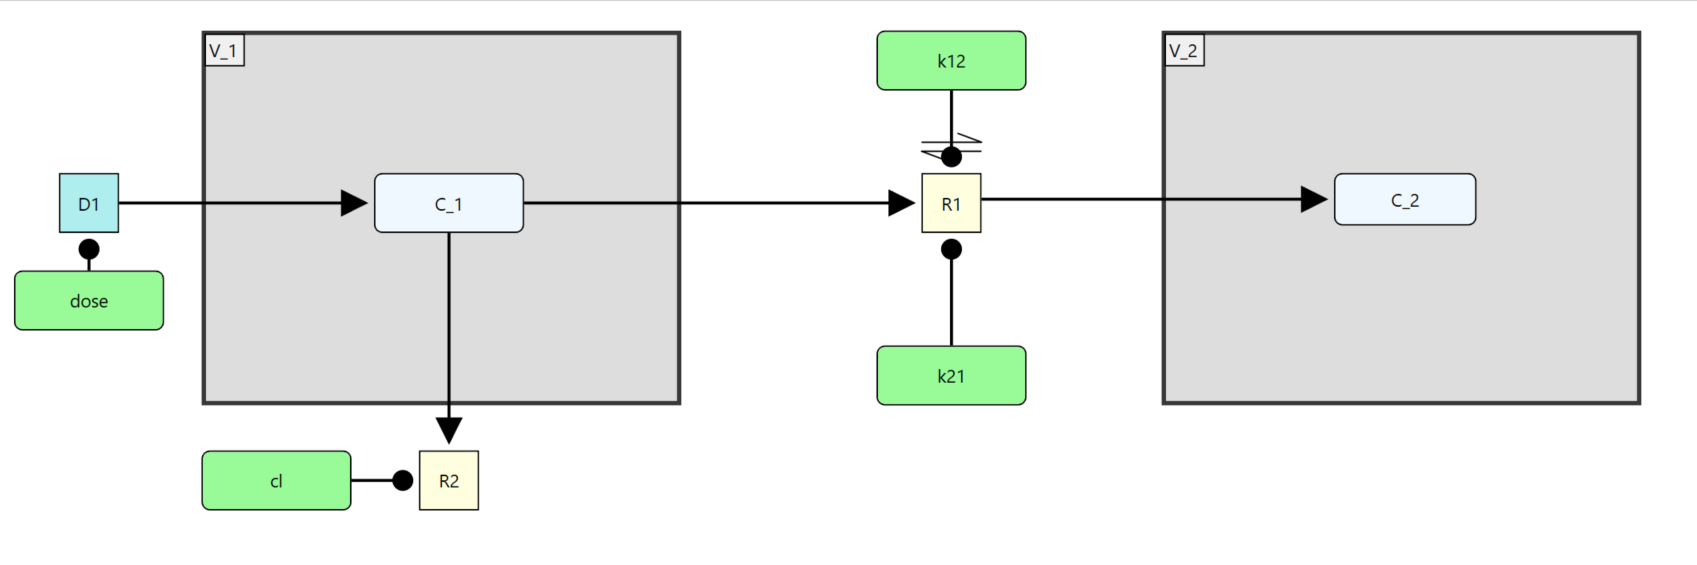

Model is saved as `basic_model.qsp`

### QSP Designer Outputs

Simple 2-compartment model in QSP Designer, a 1 mg bolus dose `D1` is administered to `V_1` at `t = 0` and simulated for 24 hours. `QSPStates.csv` is the output csv file from QSP Designer.

Text(0, 0.5, 'Concentration (mg / L)')

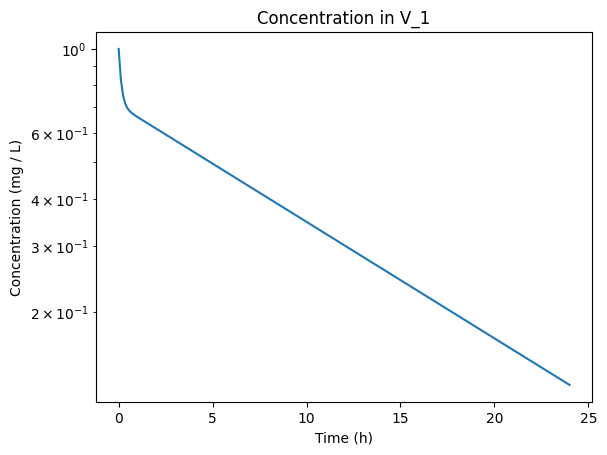

In [2]:
designer_out = pd.read_csv("QSPStates.csv")
designer_out.columns = ["id", "t", "C_1", "C_2"]

plt.plot(designer_out.t, designer_out.C_1)
plt.yscale("log")
plt.title("Concentration in V_1")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

Text(0, 0.5, 'Concentration (mg / L)')

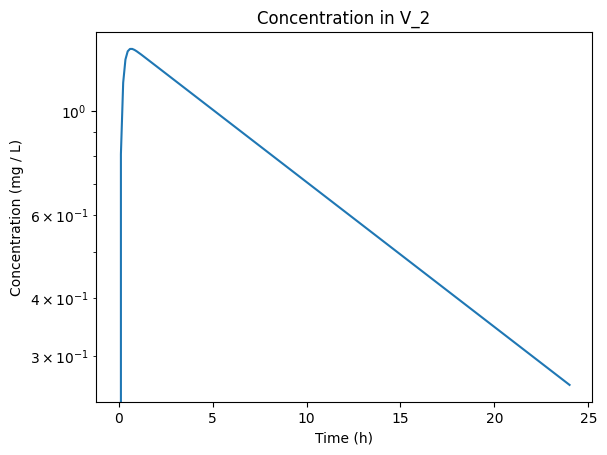

In [3]:
plt.plot(designer_out.t, designer_out.C_2)
plt.yscale("log")
plt.title("Concentration in V_2")
plt.xlabel("Time (h)")
plt.ylabel("Concentration (mg / L)")

## Running in Notebook

### Basic Model Run

We can run the model in Notebook using the normal `simulate` interface. The Designer model is passed using the `models` argument.

*NB: as of the current beta release, the notebook will return amount units for all states in the model, regardless of whether they are specified in amount or concentration units in QSP Designer* 

In [4]:
# As in Designer, model is simulated for 1 mg dose for 24 hours at 200 timepoints
times = abm.linspace(0, 24, 200, "hr")
parameters = pd.DataFrame(columns=["parameter", "value", "unit"], data=[["dose", 1.0, "mg"]])
sim = abm.simulate(models="basic_model.qsp", parameters=parameters, times=times)
output_df = sim.to_pandas(tall_outputs=False)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

In [5]:
output_df.head()

,id,t,V_2,V_1,k12,k21,cl,dose,C_1,C_2
0,0,0.000000,0.2,1.0,2.0,1.0,0.1,1.0,1.000000,0.000000
1,0,0.120603,0.2,1.0,2.0,1.0,0.1,1.0,0.827270,0.161852
2,0,0.241206,0.2,1.0,2.0,1.0,0.1,1.0,0.749866,0.229805
3,0,0.361809,0.2,1.0,2.0,1.0,0.1,1.0,0.713329,0.257546
4,0,0.482412,0.2,1.0,2.0,1.0,0.1,1.0,0.694326,0.268071


In [6]:
# Units of the simulation are exposed in the return value, and can be accessed using
# this approach.
sim.to_data_frame().data_types

{'id': Integer64(),
 't': Float64(unit='hr'),
 'V_2': Float64(unit='L'),
 'V_1': Float64(unit='L'),
 'k12': Float64(unit='L/hr'),
 'k21': Float64(unit='L/hr'),
 'cl': Float64(unit='1/hr'),
 'dose': Float64(unit='mg'),
 'C_1': Float64(unit='mg/L*L'),
 'C_2': Float64(unit='mg/L*L')}

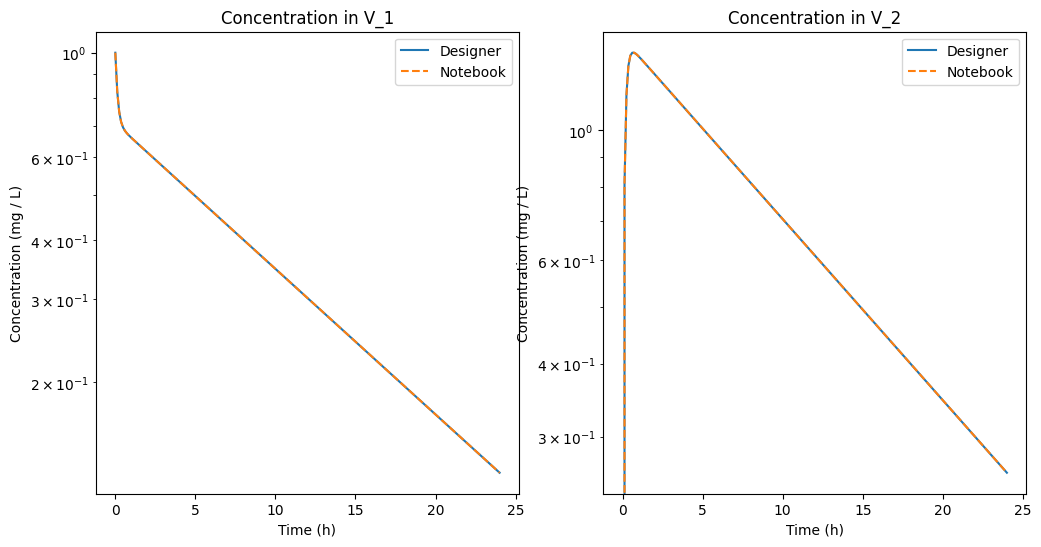

In [7]:
# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Compare trajectories with Designer
axes[0].plot(designer_out.t, designer_out.C_1, label="Designer")
axes[1].plot(designer_out.t, designer_out.C_2, label="Designer")

# Convert simulation amount units to concentration units by dividing by volume
axes[0].plot(output_df.t, output_df.C_1 / output_df.V_1, label="Notebook", linestyle="dashed")
axes[0].set_yscale("log")
axes[0].set_title("Concentration in V_1")
axes[0].set_xlabel("Time (h)")
axes[0].set_ylabel("Concentration (mg / L)")

axes[0].legend()

# Convert simulation amount units to concentration units by dividing by volume
axes[1].plot(output_df.t, output_df.C_2 / output_df.V_2, label="Notebook", linestyle="dashed")
axes[1].set_yscale("log")
axes[1].set_title("Concentration in V_2")
axes[1].set_xlabel("Time (h)")
axes[1].set_ylabel("Concentration (mg / L)")

axes[1].legend()

### Further Example

Here we use the parameter table to simulate 3 dosing regimes, `1, 2 and 3 mg`

In [8]:
multi_params = pd.DataFrame(
    columns=["dose_id", "parameter", "value", "unit"], 
    data=[[0, "dose", 1.0, "mg"], [1, "dose", 2.0, "mg"], [2, "dose", 3.0, "mg"]]
)
simulations = pd.DataFrame(columns = ["dose_id"], data=multi_params.dose_id)

In [9]:
multi_sim = abm.simulate(models="basic_model.qsp", simulations=simulations, parameters=multi_params, times=times)
multi_df = multi_sim.to_pandas(tall_outputs=False)
# Rescale to concentration
multi_df.C_1 = multi_df.C_1 / multi_df.V_1
multi_df.C_2 = multi_df.C_2 / multi_df.V_2

Total: 0, Running: 0, Succeeded: 0, Failed: 0

/opt/pixi/cache/envs/qsp-notebook-training-3044541073508600004/envs/default/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


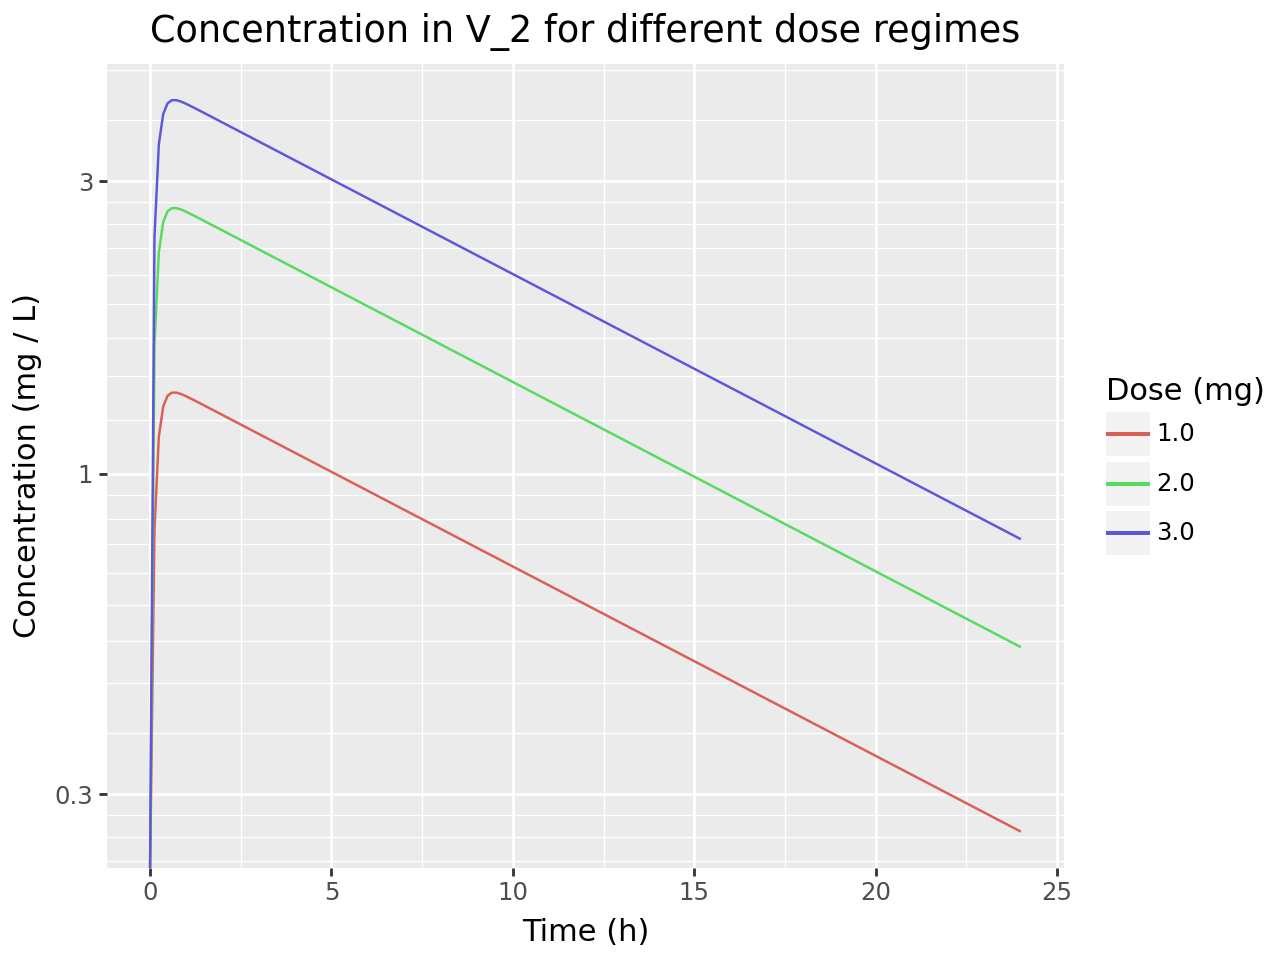

In [10]:
# p9 plot as an alternative example

(
    p9.ggplot(multi_df, p9.aes(x="t", y="C_2", color="factor(dose)", group="dose")) + 
    p9.ggtitle("Concentration in V_2 for different dose regimes") + 
    p9.geom_line() +
    p9.scale_y_log10() + 
    p9.labs(x="Time (h)", y = "Concentration (mg / L)", color="Dose (mg)")
)

# Debugging
This is likely not needed, but can be useful if something about your model is not behaving as expected. You can inspect how a  QSP Designer model has been imported as a Notebook model object using the following commands.

In [11]:
# Find the ID of the model in the system
model_id = sim._simulations[0].model.model_id

In [12]:
# Get the model creation job from ID using the abm SDK
model_job = abm._sdk.job.Job.from_id(model_id, include_types=True).refresh()

The model object has the parameters and outputs for inspection.

In [13]:
print(model_job.types.parameters)

{'k12': ExternalParameter(value=2.0, unit=Divide(left=Atom(symbol='L'), right=Atom(symbol='hr'))), 'k21': ExternalParameter(value=1.0, unit=Divide(left=Atom(symbol='L'), right=Atom(symbol='hr'))), 'cl': ExternalParameter(value=0.1, unit=Divide(left=Dimensionless(), right=Atom(symbol='hr'))), 'dose': ExternalParameter(value=1.0, unit=Atom(symbol='mg'))}


In [14]:
print(model_job.types.outputs)

{'V_2': ExternalOutput(unit=Atom(symbol='L')), 'V_1': ExternalOutput(unit=Atom(symbol='L')), 'k12': ExternalOutput(unit=Divide(left=Atom(symbol='L'), right=Atom(symbol='hr'))), 'k21': ExternalOutput(unit=Divide(left=Atom(symbol='L'), right=Atom(symbol='hr'))), 'cl': ExternalOutput(unit=Divide(left=Dimensionless(), right=Atom(symbol='hr'))), 'dose': ExternalOutput(unit=Atom(symbol='mg')), 'C_1': ExternalOutput(unit=Multiply(left=Divide(left=Atom(symbol='mg'), right=Atom(symbol='L')), right=Atom(symbol='L'))), 'C_2': ExternalOutput(unit=Multiply(left=Divide(left=Atom(symbol='mg'), right=Atom(symbol='L')), right=Atom(symbol='L')))}
